## Classifying Bad Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [1]:
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 2

Autosaving every 2 seconds


### Set network parameters

In [2]:
# Dataset/Featurization Config
path = 'data/full_cols_bad_50k.csv'
label = 'bad'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisbad_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [3]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [4]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 8.3 s, sys: 20 ms, total: 8.32 s
Wall time: 8.31 s


### Configure dataset

In [5]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/full_cols_bad_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 31min 20s, sys: 1min 26s, total: 32min 46s
Wall time: 6min 28s


### Prepare model configurations

In [6]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [7]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [8]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [9]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Train model

In [11]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.674998, Training Accuracy= 0.46667
Iter 300, Minibatch Loss= 0.685086, Training Accuracy= 0.66667
Iter 450, Minibatch Loss= 0.634806, Training Accuracy= 0.66667
Iter 600, Minibatch Loss= 0.636626, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.655095, Training Accuracy= 0.53333
Validation Accuracy: 0.65472
Validation Loss: 0.6579635


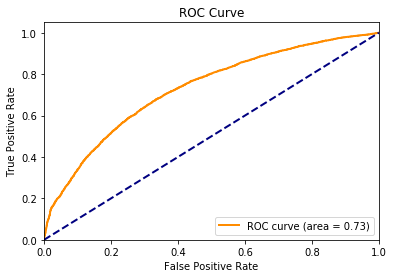

Iter 900, Minibatch Loss= 0.614614, Training Accuracy= 0.66667
Iter 1050, Minibatch Loss= 0.614035, Training Accuracy= 0.66667
Iter 1200, Minibatch Loss= 0.630617, Training Accuracy= 0.80000
Iter 1350, Minibatch Loss= 0.610979, Training Accuracy= 0.60000
Iter 1500, Minibatch Loss= 0.760635, Training Accuracy= 0.60000
Validation Accuracy: 0.5944
Validation Loss: 0.67412376
Iter 1650, Minibatch Loss= 0.734914, Training Accuracy= 0.66667
Iter 1800, Minibatch Loss= 0.615586, Training Accuracy= 0.86667
Iter 1950, Minibatch Loss= 0.521031, Training Accuracy= 0.86667
Iter 2100, Minibatch Loss= 0.560221, Training Accuracy= 0.66667
Iter 2250, Minibatch Loss= 0.581567, Training Accuracy= 0.80000
Validation Accuracy: 0.67368
Validation Loss: 0.6196881


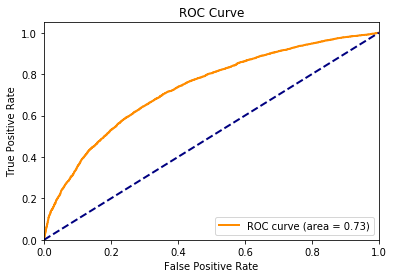

Iter 2400, Minibatch Loss= 0.699464, Training Accuracy= 0.53333
Iter 2550, Minibatch Loss= 0.640774, Training Accuracy= 0.60000
Iter 2700, Minibatch Loss= 0.703100, Training Accuracy= 0.53333
Iter 2850, Minibatch Loss= 0.545877, Training Accuracy= 0.66667
Iter 3000, Minibatch Loss= 0.628595, Training Accuracy= 0.66667
Validation Accuracy: 0.64064
Validation Loss: 0.6300069
Iter 3150, Minibatch Loss= 0.676848, Training Accuracy= 0.66667
Iter 3300, Minibatch Loss= 0.515464, Training Accuracy= 0.86667
Iter 3450, Minibatch Loss= 0.715375, Training Accuracy= 0.53333
Iter 3600, Minibatch Loss= 0.782801, Training Accuracy= 0.33333
Iter 3750, Minibatch Loss= 0.590414, Training Accuracy= 0.73333
Validation Accuracy: 0.67912
Validation Loss: 0.62075293


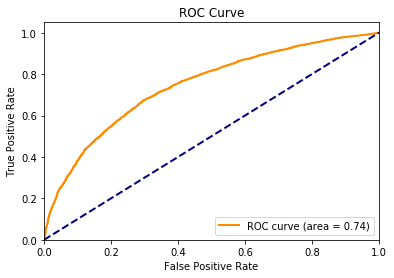

Iter 3900, Minibatch Loss= 0.622380, Training Accuracy= 0.66667
Iter 4050, Minibatch Loss= 0.528619, Training Accuracy= 0.60000
Iter 4200, Minibatch Loss= 0.643705, Training Accuracy= 0.60000
Iter 4350, Minibatch Loss= 0.575548, Training Accuracy= 0.80000
Iter 4500, Minibatch Loss= 0.602061, Training Accuracy= 0.60000
Validation Accuracy: 0.67896
Validation Loss: 0.6059796
Iter 4650, Minibatch Loss= 0.562576, Training Accuracy= 0.73333
Iter 4800, Minibatch Loss= 0.585640, Training Accuracy= 0.60000
Iter 4950, Minibatch Loss= 0.611049, Training Accuracy= 0.60000
Iter 5100, Minibatch Loss= 0.560996, Training Accuracy= 0.73333
Iter 5250, Minibatch Loss= 0.528009, Training Accuracy= 0.80000
Validation Accuracy: 0.68456
Validation Loss: 0.60258263


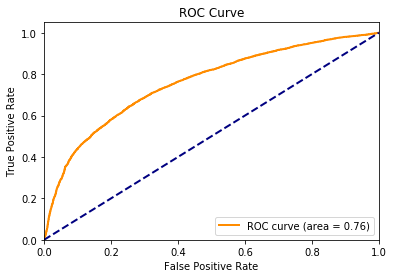

Iter 5400, Minibatch Loss= 0.545966, Training Accuracy= 0.73333
Iter 5550, Minibatch Loss= 0.687004, Training Accuracy= 0.53333
Iter 5700, Minibatch Loss= 0.609340, Training Accuracy= 0.73333
Iter 5850, Minibatch Loss= 0.576468, Training Accuracy= 0.86667
Iter 6000, Minibatch Loss= 0.798977, Training Accuracy= 0.53333
Validation Accuracy: 0.6932
Validation Loss: 0.59853756


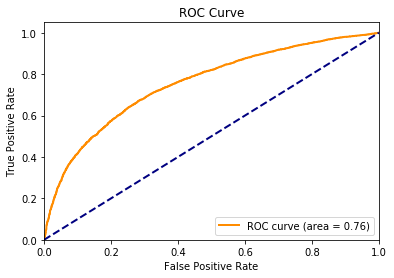

Iter 6150, Minibatch Loss= 0.584326, Training Accuracy= 0.73333
Iter 6300, Minibatch Loss= 0.803569, Training Accuracy= 0.53333
Iter 6450, Minibatch Loss= 0.595421, Training Accuracy= 0.46667
Iter 6600, Minibatch Loss= 0.577862, Training Accuracy= 0.66667
Iter 6750, Minibatch Loss= 0.542823, Training Accuracy= 0.73333
Validation Accuracy: 0.69584
Validation Loss: 0.59708196


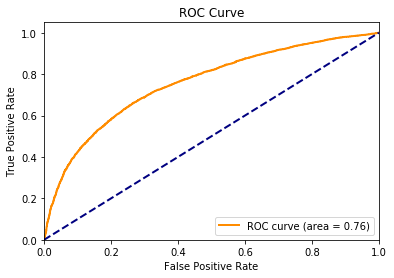

Iter 6900, Minibatch Loss= 0.602399, Training Accuracy= 0.80000
Iter 7050, Minibatch Loss= 0.540659, Training Accuracy= 0.60000
Iter 7200, Minibatch Loss= 0.634085, Training Accuracy= 0.73333
Iter 7350, Minibatch Loss= 0.456864, Training Accuracy= 0.66667
Iter 7500, Minibatch Loss= 0.541492, Training Accuracy= 0.73333
Validation Accuracy: 0.70224
Validation Loss: 0.5902512


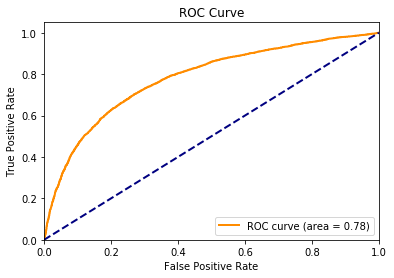

Iter 7650, Minibatch Loss= 0.542446, Training Accuracy= 0.80000
Iter 7800, Minibatch Loss= 0.418102, Training Accuracy= 0.86667
Iter 7950, Minibatch Loss= 0.801926, Training Accuracy= 0.46667
Iter 8100, Minibatch Loss= 0.523809, Training Accuracy= 0.86667
Iter 8250, Minibatch Loss= 0.547146, Training Accuracy= 0.80000
Validation Accuracy: 0.71192
Validation Loss: 0.57584566


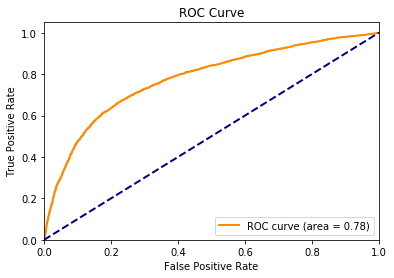

Iter 8400, Minibatch Loss= 0.457070, Training Accuracy= 0.80000
Iter 8550, Minibatch Loss= 0.506787, Training Accuracy= 0.73333
Iter 8700, Minibatch Loss= 0.926532, Training Accuracy= 0.66667
Iter 8850, Minibatch Loss= 0.422578, Training Accuracy= 0.93333
Iter 9000, Minibatch Loss= 0.848433, Training Accuracy= 0.60000
Validation Accuracy: 0.65608
Validation Loss: 0.6249893
Iter 9150, Minibatch Loss= 0.579826, Training Accuracy= 0.66667
Iter 9300, Minibatch Loss= 0.511672, Training Accuracy= 0.73333
Iter 9450, Minibatch Loss= 0.488486, Training Accuracy= 0.93333
Iter 9600, Minibatch Loss= 0.399274, Training Accuracy= 0.86667
Iter 9750, Minibatch Loss= 0.508263, Training Accuracy= 0.73333
Validation Accuracy: 0.71632
Validation Loss: 0.57746243


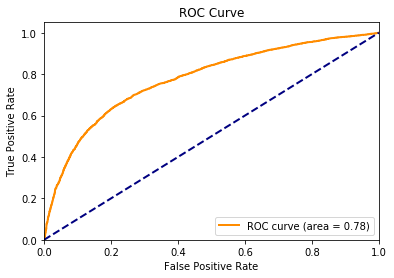

Iter 9900, Minibatch Loss= 0.564818, Training Accuracy= 0.73333
Iter 10050, Minibatch Loss= 0.354960, Training Accuracy= 0.93333
Iter 10200, Minibatch Loss= 0.583645, Training Accuracy= 0.73333
Iter 10350, Minibatch Loss= 0.478516, Training Accuracy= 0.86667
Iter 10500, Minibatch Loss= 0.602788, Training Accuracy= 0.73333
Validation Accuracy: 0.67808
Validation Loss: 0.5959616
Iter 10650, Minibatch Loss= 0.403296, Training Accuracy= 0.93333
Iter 10800, Minibatch Loss= 0.403581, Training Accuracy= 0.80000
Iter 10950, Minibatch Loss= 0.771337, Training Accuracy= 0.53333
Iter 11100, Minibatch Loss= 0.698446, Training Accuracy= 0.46667
Iter 11250, Minibatch Loss= 0.491746, Training Accuracy= 0.80000
Validation Accuracy: 0.69472
Validation Loss: 0.5886014
Iter 11400, Minibatch Loss= 0.562324, Training Accuracy= 0.66667
Iter 11550, Minibatch Loss= 1.650898, Training Accuracy= 0.66667
Iter 11700, Minibatch Loss= 0.462149, Training Accuracy= 0.86667
Iter 11850, Minibatch Loss= 0.579175, Traini

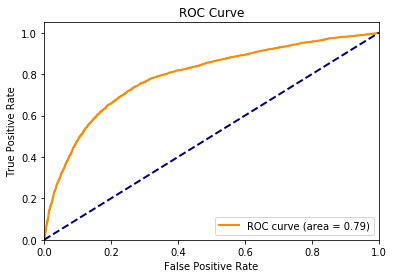

Iter 15150, Minibatch Loss= 0.435330, Training Accuracy= 0.86667
Iter 15300, Minibatch Loss= 0.422913, Training Accuracy= 0.80000
Iter 15450, Minibatch Loss= 0.571241, Training Accuracy= 0.73333
Iter 15600, Minibatch Loss= 0.479809, Training Accuracy= 0.93333
Iter 15750, Minibatch Loss= 0.611007, Training Accuracy= 0.66667
Validation Accuracy: 0.70384
Validation Loss: 0.58567405
Iter 15900, Minibatch Loss= 0.561355, Training Accuracy= 0.80000
Iter 16050, Minibatch Loss= 0.306977, Training Accuracy= 0.93333
Iter 16200, Minibatch Loss= 0.359253, Training Accuracy= 0.86667
Iter 16350, Minibatch Loss= 0.555346, Training Accuracy= 0.73333
Iter 16500, Minibatch Loss= 0.700046, Training Accuracy= 0.46667
Validation Accuracy: 0.66768
Validation Loss: 0.6048325
Iter 16650, Minibatch Loss= 0.597481, Training Accuracy= 0.66667
Iter 16800, Minibatch Loss= 0.593444, Training Accuracy= 0.73333
Iter 16950, Minibatch Loss= 0.636459, Training Accuracy= 0.73333
Iter 17100, Minibatch Loss= 0.472263, Trai

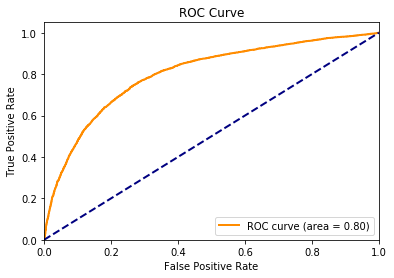

Iter 17400, Minibatch Loss= 0.801769, Training Accuracy= 0.73333
Iter 17550, Minibatch Loss= 0.515872, Training Accuracy= 0.73333
Iter 17700, Minibatch Loss= 0.452770, Training Accuracy= 0.86667
Iter 17850, Minibatch Loss= 0.563117, Training Accuracy= 0.66667
Iter 18000, Minibatch Loss= 0.379701, Training Accuracy= 0.86667
Validation Accuracy: 0.73944
Validation Loss: 0.5588012


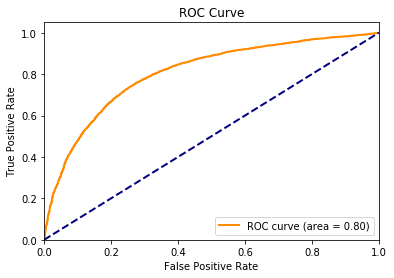

Iter 18150, Minibatch Loss= 0.640215, Training Accuracy= 0.60000
Iter 18300, Minibatch Loss= 0.646181, Training Accuracy= 0.73333
Iter 18450, Minibatch Loss= 0.514491, Training Accuracy= 0.73333
Iter 18600, Minibatch Loss= 0.583954, Training Accuracy= 0.66667
Iter 18750, Minibatch Loss= 0.583048, Training Accuracy= 0.73333
Validation Accuracy: 0.73896
Validation Loss: 0.5448127
Iter 18900, Minibatch Loss= 0.569515, Training Accuracy= 0.73333
Iter 19050, Minibatch Loss= 0.388298, Training Accuracy= 0.86667
Iter 19200, Minibatch Loss= 0.642524, Training Accuracy= 0.60000
Iter 19350, Minibatch Loss= 0.383765, Training Accuracy= 0.93333
Iter 19500, Minibatch Loss= 0.472046, Training Accuracy= 0.86667
Validation Accuracy: 0.72576
Validation Loss: 0.551014
Iter 19650, Minibatch Loss= 0.464742, Training Accuracy= 0.80000
Iter 19800, Minibatch Loss= 0.520073, Training Accuracy= 0.80000
Iter 19950, Minibatch Loss= 0.561922, Training Accuracy= 0.73333
Iter 20100, Minibatch Loss= 0.700583, Traini

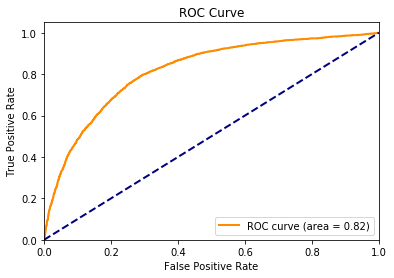

Iter 20400, Minibatch Loss= 0.489071, Training Accuracy= 0.80000
Iter 20550, Minibatch Loss= 0.534027, Training Accuracy= 0.73333
Iter 20700, Minibatch Loss= 0.352233, Training Accuracy= 0.86667
Iter 20850, Minibatch Loss= 0.598084, Training Accuracy= 0.66667
Iter 21000, Minibatch Loss= 0.311425, Training Accuracy= 0.93333
Validation Accuracy: 0.7484
Validation Loss: 0.54037434


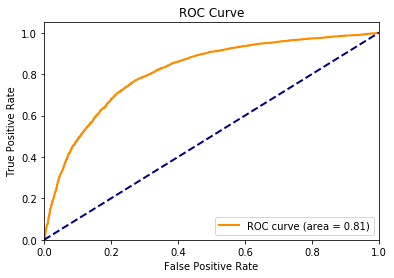

Iter 21150, Minibatch Loss= 0.656849, Training Accuracy= 0.73333
Iter 21300, Minibatch Loss= 0.521302, Training Accuracy= 0.86667
Iter 21450, Minibatch Loss= 0.591536, Training Accuracy= 0.73333
Iter 21600, Minibatch Loss= 0.374686, Training Accuracy= 0.86667
Iter 21750, Minibatch Loss= 0.686324, Training Accuracy= 0.60000
Validation Accuracy: 0.7176
Validation Loss: 0.572847
Iter 21900, Minibatch Loss= 0.409681, Training Accuracy= 0.93333
Iter 22050, Minibatch Loss= 0.498888, Training Accuracy= 0.73333
Iter 22200, Minibatch Loss= 0.556119, Training Accuracy= 0.66667
Iter 22350, Minibatch Loss= 0.373200, Training Accuracy= 0.86667
Iter 22500, Minibatch Loss= 0.543940, Training Accuracy= 0.73333
Validation Accuracy: 0.7488
Validation Loss: 0.547196


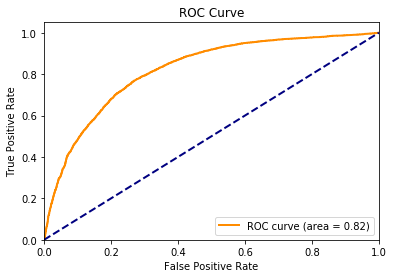

Iter 22650, Minibatch Loss= 0.386085, Training Accuracy= 0.86667
Iter 22800, Minibatch Loss= 0.497856, Training Accuracy= 0.80000
Iter 22950, Minibatch Loss= 0.603819, Training Accuracy= 0.60000
Iter 23100, Minibatch Loss= 0.557984, Training Accuracy= 0.80000
Iter 23250, Minibatch Loss= 0.548135, Training Accuracy= 0.66667
Validation Accuracy: 0.70816
Validation Loss: 0.57102644
Iter 23400, Minibatch Loss= 0.533159, Training Accuracy= 0.80000
Iter 23550, Minibatch Loss= 0.273754, Training Accuracy= 0.93333
Iter 23700, Minibatch Loss= 0.481961, Training Accuracy= 0.80000
Iter 23850, Minibatch Loss= 0.558192, Training Accuracy= 0.73333
Iter 24000, Minibatch Loss= 0.617112, Training Accuracy= 0.73333
Validation Accuracy: 0.73792
Validation Loss: 0.55271155
Iter 24150, Minibatch Loss= 0.447063, Training Accuracy= 0.80000
Iter 24300, Minibatch Loss= 0.631721, Training Accuracy= 0.73333
Iter 24450, Minibatch Loss= 0.444798, Training Accuracy= 0.86667
Iter 24600, Minibatch Loss= 0.501629, Tra

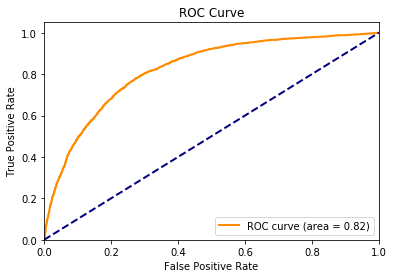

Iter 24900, Minibatch Loss= 0.640036, Training Accuracy= 0.73333
Iter 25050, Minibatch Loss= 0.563394, Training Accuracy= 0.73333
Iter 25200, Minibatch Loss= 0.675799, Training Accuracy= 0.66667
Iter 25350, Minibatch Loss= 0.539977, Training Accuracy= 0.80000
Iter 25500, Minibatch Loss= 0.370861, Training Accuracy= 0.86667
Validation Accuracy: 0.74416
Validation Loss: 0.53475976
Iter 25650, Minibatch Loss= 0.826563, Training Accuracy= 0.46667
Iter 25800, Minibatch Loss= 0.375714, Training Accuracy= 0.80000
Iter 25950, Minibatch Loss= 0.620081, Training Accuracy= 0.73333
Iter 26100, Minibatch Loss= 0.519653, Training Accuracy= 0.80000
Iter 26250, Minibatch Loss= 0.421637, Training Accuracy= 0.86667
Validation Accuracy: 0.74552
Validation Loss: 0.54512644
Iter 26400, Minibatch Loss= 0.653106, Training Accuracy= 0.60000
Iter 26550, Minibatch Loss= 0.530294, Training Accuracy= 0.80000
Iter 26700, Minibatch Loss= 0.483182, Training Accuracy= 0.80000
Iter 26850, Minibatch Loss= 0.748758, Tra

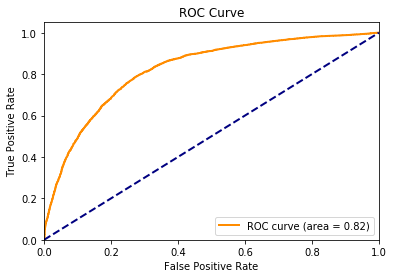

Iter 45900, Minibatch Loss= 0.471088, Training Accuracy= 0.86667
Iter 46050, Minibatch Loss= 0.400153, Training Accuracy= 0.86667
Iter 46200, Minibatch Loss= 0.797953, Training Accuracy= 0.60000
Iter 46350, Minibatch Loss= 0.387661, Training Accuracy= 0.86667
Iter 46500, Minibatch Loss= 0.680605, Training Accuracy= 0.60000
Validation Accuracy: 0.75304
Validation Loss: 0.5222175
Iter 46650, Minibatch Loss= 0.540554, Training Accuracy= 0.80000
Iter 46800, Minibatch Loss= 0.347516, Training Accuracy= 0.93333
Iter 46950, Minibatch Loss= 0.466890, Training Accuracy= 0.73333
Iter 47100, Minibatch Loss= 0.317279, Training Accuracy= 0.93333
Iter 47250, Minibatch Loss= 0.539478, Training Accuracy= 0.80000
Validation Accuracy: 0.74152
Validation Loss: 0.54443985
Iter 47400, Minibatch Loss= 0.539091, Training Accuracy= 0.80000
Iter 47550, Minibatch Loss= 0.254216, Training Accuracy= 0.93333
Iter 47700, Minibatch Loss= 0.423800, Training Accuracy= 0.80000
Iter 47850, Minibatch Loss= 0.304541, Trai

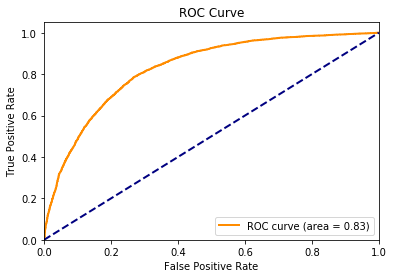

Iter 63150, Minibatch Loss= 0.665074, Training Accuracy= 0.53333
Iter 63300, Minibatch Loss= 0.275026, Training Accuracy= 0.86667
Iter 63450, Minibatch Loss= 0.688250, Training Accuracy= 0.66667
Iter 63600, Minibatch Loss= 0.483740, Training Accuracy= 0.73333
Iter 63750, Minibatch Loss= 0.432303, Training Accuracy= 0.86667
Validation Accuracy: 0.73328
Validation Loss: 0.5400351
Iter 63900, Minibatch Loss= 0.618687, Training Accuracy= 0.60000
Iter 64050, Minibatch Loss= 0.576788, Training Accuracy= 0.80000
Iter 64200, Minibatch Loss= 0.486548, Training Accuracy= 0.80000
Iter 64350, Minibatch Loss= 0.758211, Training Accuracy= 0.53333
Iter 64500, Minibatch Loss= 0.468004, Training Accuracy= 0.80000
Validation Accuracy: 0.74296
Validation Loss: 0.5445117
Iter 64650, Minibatch Loss= 0.307794, Training Accuracy= 0.80000
Iter 64800, Minibatch Loss= 0.972282, Training Accuracy= 0.53333
Iter 64950, Minibatch Loss= 0.454100, Training Accuracy= 0.86667
Iter 65100, Minibatch Loss= 0.753548, Train

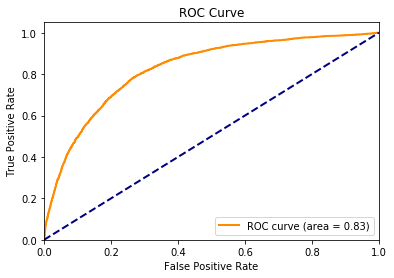

Checkpoint saved at chkpts/model_genesisbad_run1.ckpt
Iter 75150, Minibatch Loss= 0.512281, Training Accuracy= 0.80000
Iter 75300, Minibatch Loss= 0.557870, Training Accuracy= 0.73333
Iter 75450, Minibatch Loss= 0.666855, Training Accuracy= 0.73333
Iter 75600, Minibatch Loss= 0.421688, Training Accuracy= 0.86667
Iter 75750, Minibatch Loss= 0.406286, Training Accuracy= 0.80000
Validation Accuracy: 0.75232
Validation Loss: 0.5164741
Iter 75900, Minibatch Loss= 0.330385, Training Accuracy= 0.86667
Iter 76050, Minibatch Loss= 0.378397, Training Accuracy= 0.80000
Iter 76200, Minibatch Loss= 0.462196, Training Accuracy= 0.73333
Iter 76350, Minibatch Loss= 0.598416, Training Accuracy= 0.66667
Iter 76500, Minibatch Loss= 0.698200, Training Accuracy= 0.66667
Validation Accuracy: 0.7412
Validation Loss: 0.5410829
Iter 76650, Minibatch Loss= 0.460730, Training Accuracy= 0.80000
Iter 76800, Minibatch Loss= 0.545950, Training Accuracy= 0.73333
Iter 76950, Minibatch Loss= 0.255241, Training Accuracy

In [12]:
%%time

best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))